Fail episode 0 with total attached: 7


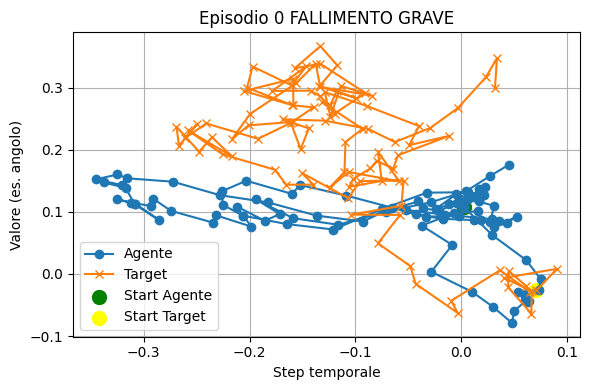

[Episode 0] Steps: 100, Total attached: 7, Mean distance: 0.1426, Success: False


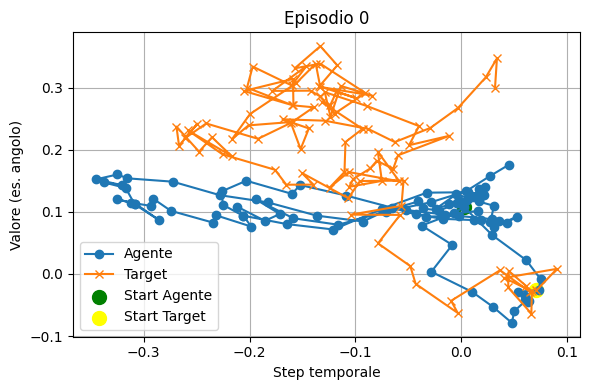

Fail episode 1 with total attached: 4


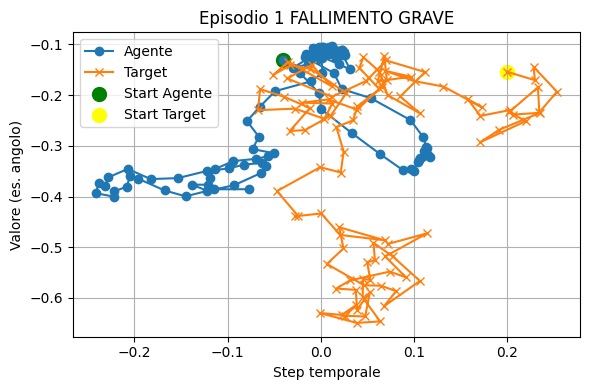

[Episode 1] Steps: 100, Total attached: 4, Mean distance: 0.1572, Success: False
Fail episode 2 with total attached: 21


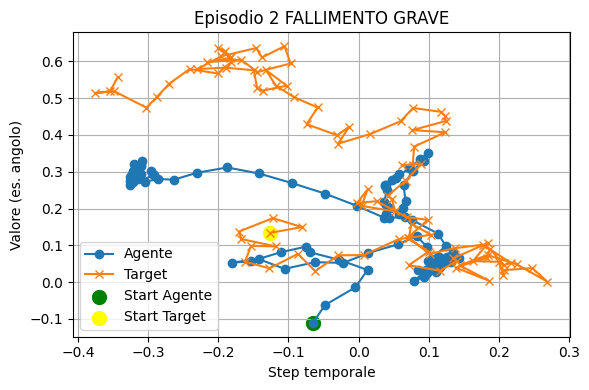

[Episode 2] Steps: 100, Total attached: 21, Mean distance: 0.1559, Success: False
Fail episode 3 with total attached: 9


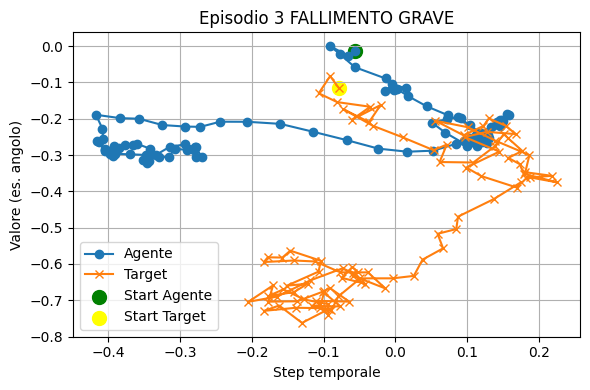

[Episode 3] Steps: 100, Total attached: 9, Mean distance: 0.1887, Success: False
Fail episode 4 with total attached: 45


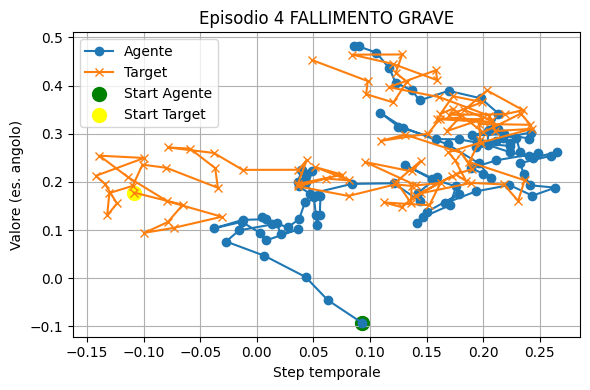

[Episode 4] Steps: 100, Total attached: 45, Mean distance: 0.1653, Success: False
Fail episode 5 with total attached: 42


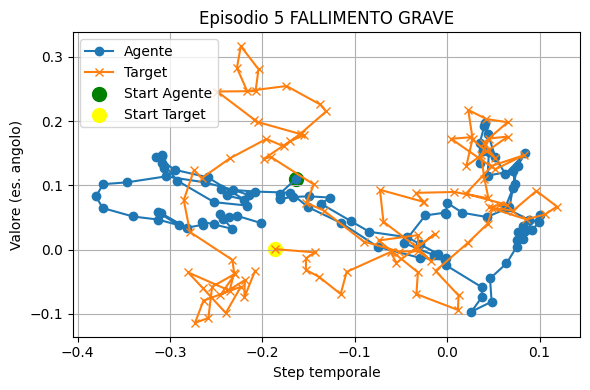

[Episode 5] Steps: 100, Total attached: 42, Mean distance: 0.1502, Success: False
Fail episode 6 with total attached: 15


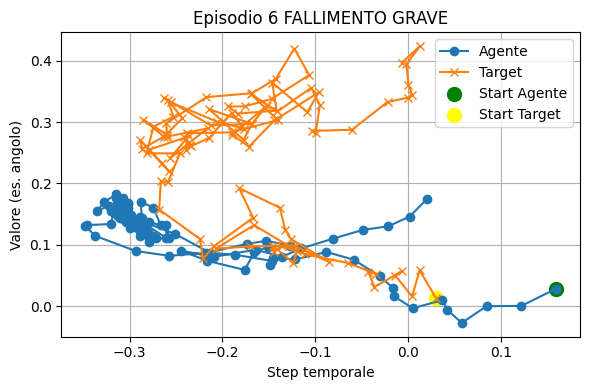

[Episode 6] Steps: 100, Total attached: 15, Mean distance: 0.1502, Success: False
Fail episode 7 with total attached: 32


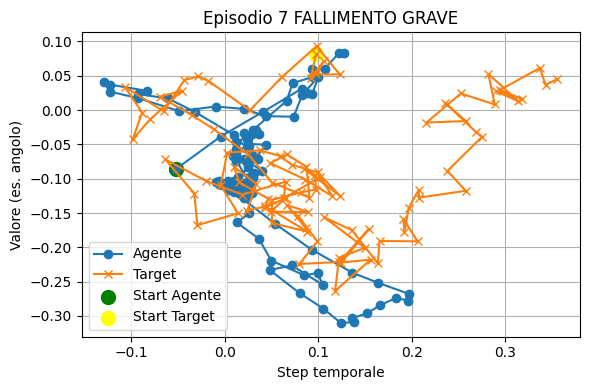

[Episode 7] Steps: 100, Total attached: 32, Mean distance: 0.1437, Success: False
Fail episode 8 with total attached: 16


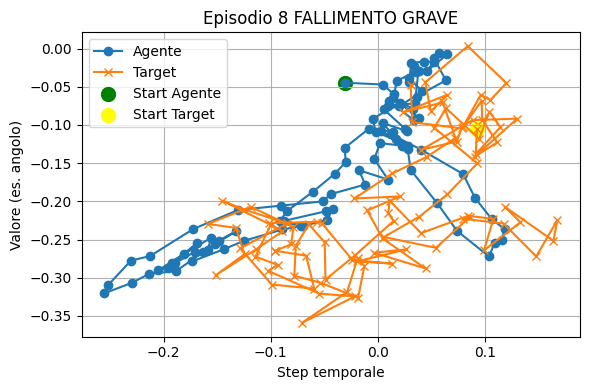

[Episode 8] Steps: 100, Total attached: 16, Mean distance: 0.1371, Success: False
Fail episode 9 with total attached: 8


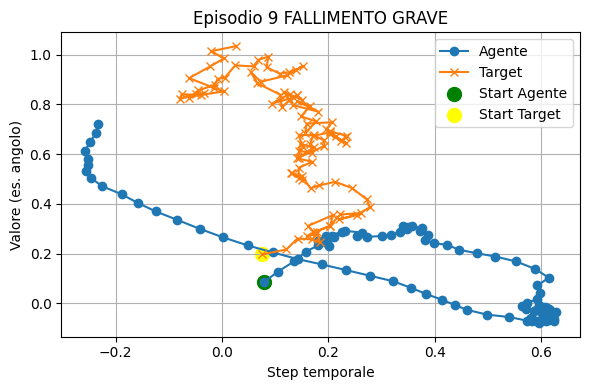

[Episode 9] Steps: 100, Total attached: 8, Mean distance: 0.1807, Success: False
Fail episode 10 with total attached: 6


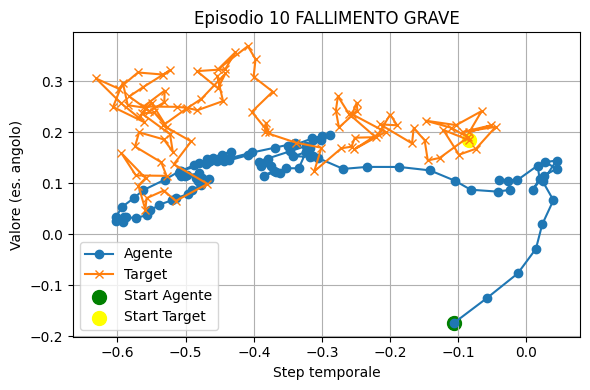

[Episode 10] Steps: 100, Total attached: 6, Mean distance: 0.1765, Success: False
Fail episode 11 with total attached: 34


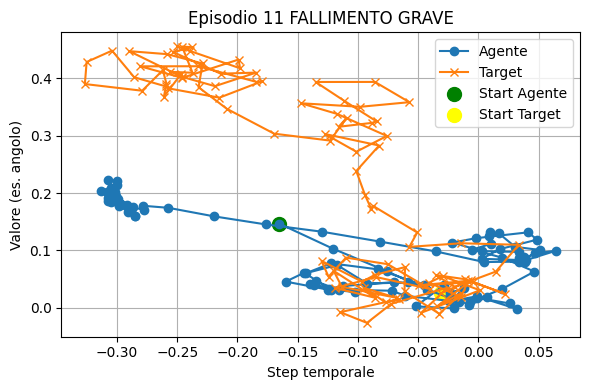

[Episode 11] Steps: 100, Total attached: 34, Mean distance: 0.1744, Success: False
Fail episode 12 with total attached: 0


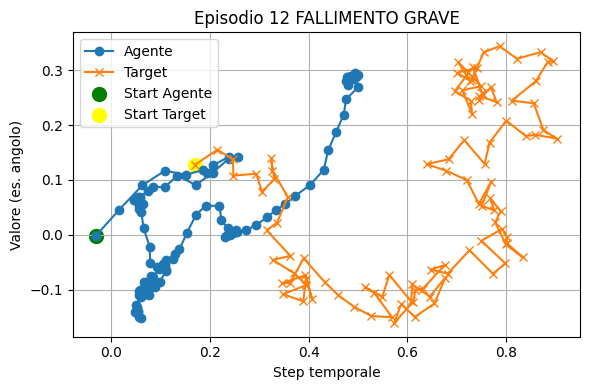

[Episode 12] Steps: 100, Total attached: 0, Mean distance: 0.1955, Success: False
Fail episode 13 with total attached: 18


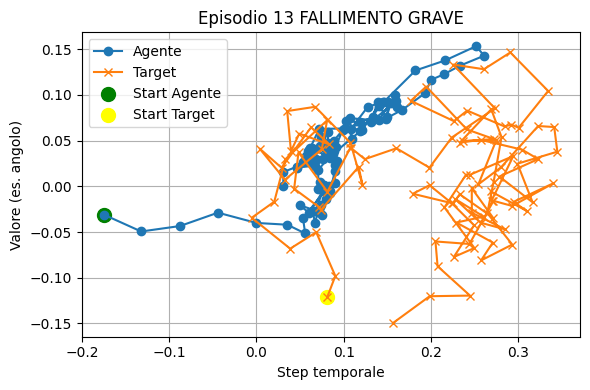

[Episode 13] Steps: 100, Total attached: 18, Mean distance: 0.1909, Success: False
Fail episode 14 with total attached: 7


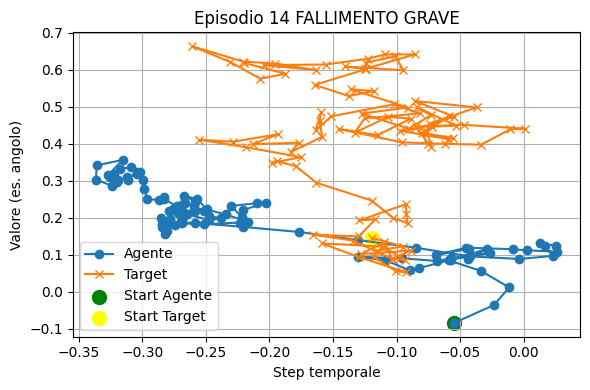

[Episode 14] Steps: 100, Total attached: 7, Mean distance: 0.1947, Success: False
Fail episode 15 with total attached: 37


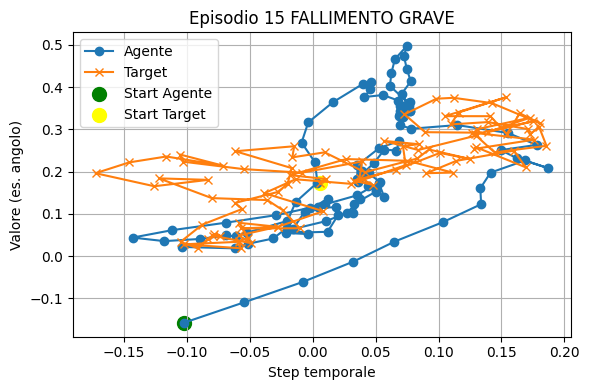

[Episode 15] Steps: 100, Total attached: 37, Mean distance: 0.1880, Success: False
Fail episode 16 with total attached: 11


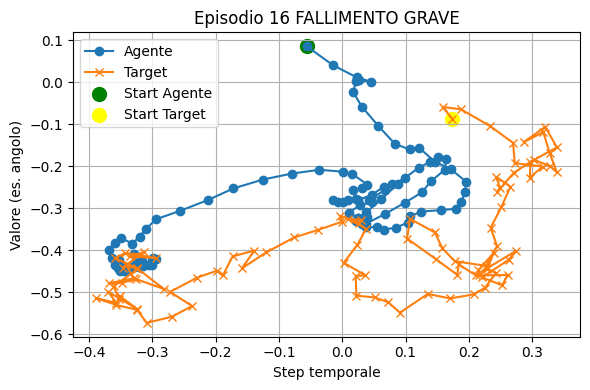

[Episode 16] Steps: 100, Total attached: 11, Mean distance: 0.1865, Success: False
Fail episode 17 with total attached: 0


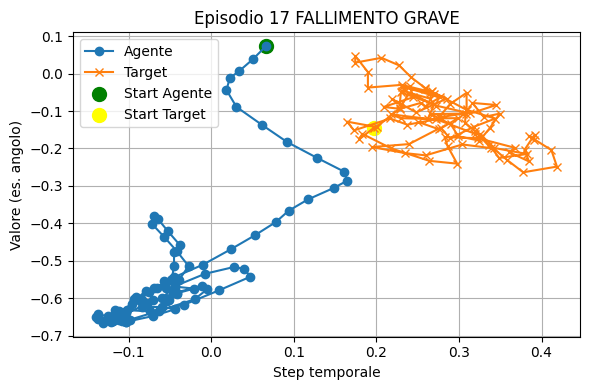

[Episode 17] Steps: 100, Total attached: 0, Mean distance: 0.2066, Success: False
Fail episode 18 with total attached: 51


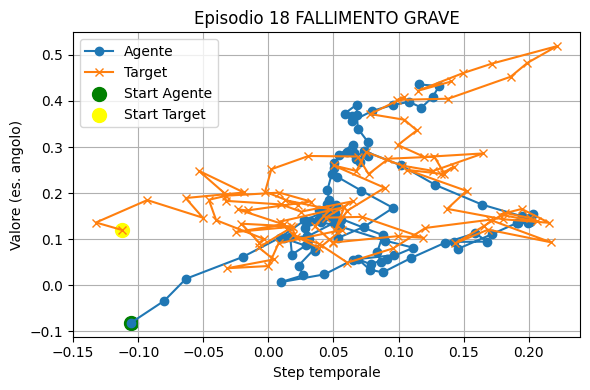

[Episode 18] Steps: 100, Total attached: 51, Mean distance: 0.1986, Success: False
Fail episode 19 with total attached: 3


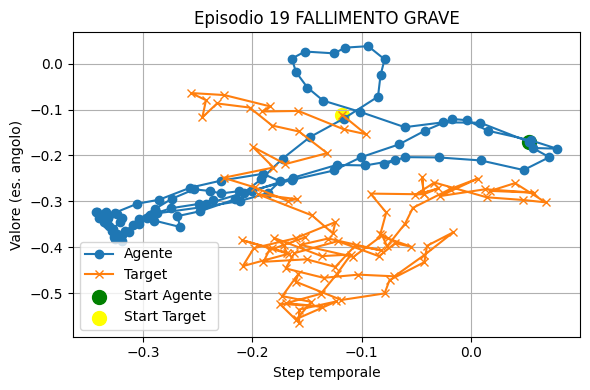

[Episode 19] Steps: 100, Total attached: 3, Mean distance: 0.1966, Success: False
Fail episode 20 with total attached: 39


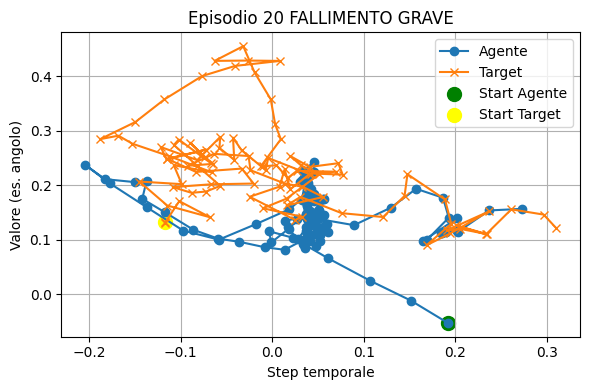

[Episode 20] Steps: 100, Total attached: 39, Mean distance: 0.1929, Success: False
Fail episode 21 with total attached: 23


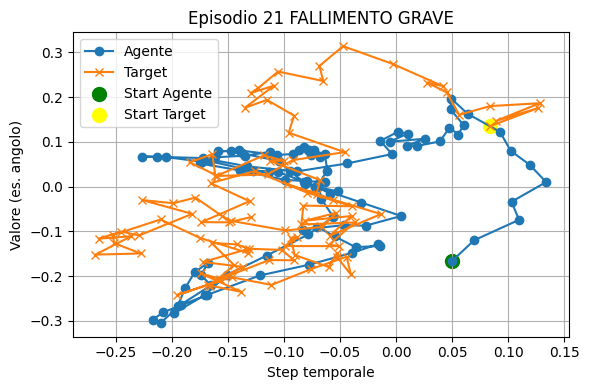

[Episode 21] Steps: 100, Total attached: 23, Mean distance: 0.1891, Success: False
Fail episode 22 with total attached: 0


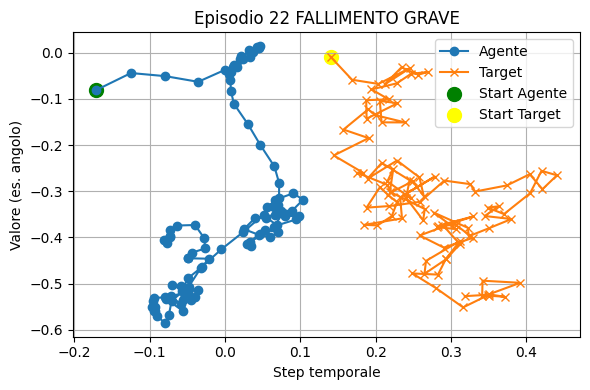

[Episode 22] Steps: 100, Total attached: 0, Mean distance: 0.1938, Success: False
Fail episode 23 with total attached: 41


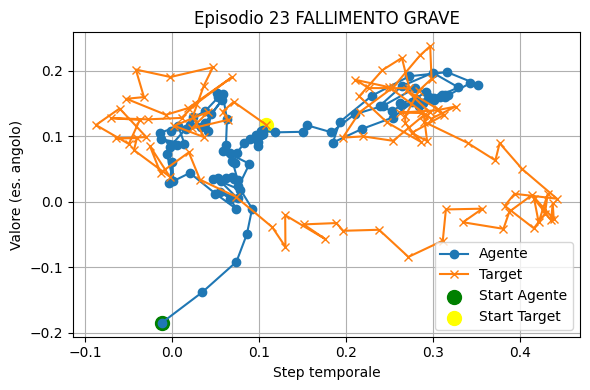

[Episode 23] Steps: 100, Total attached: 41, Mean distance: 0.1906, Success: False
Fail episode 24 with total attached: 11


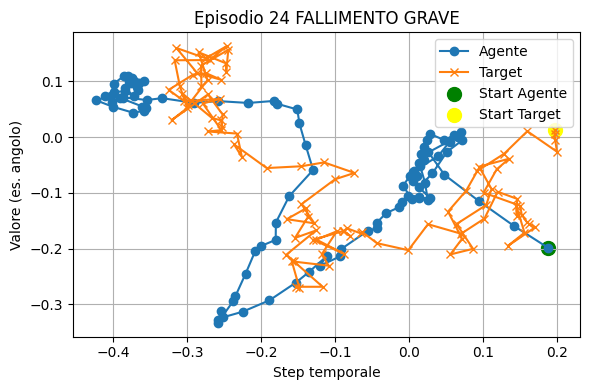

[Episode 24] Steps: 100, Total attached: 11, Mean distance: 0.1871, Success: False
Fail episode 25 with total attached: 35


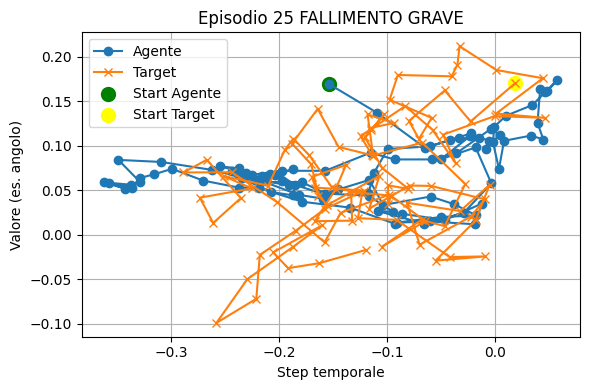

[Episode 25] Steps: 100, Total attached: 35, Mean distance: 0.1824, Success: False


KeyboardInterrupt: 

In [7]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from environment import TrackingEnv
import gymnasium as gym
#from irl_sac_transl_train import RewardNetwork, IRLEnvWrapper

device = torch.device("cpu")

class RewardNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)

    def forward(self, state, action):
        if action.ndim == 1:
            action = action.unsqueeze(1)
        x = torch.cat([state, action], dim=-1)
        return self.model(x)

# Env wrapper con reward appreso
class IRLEnvWrapper(gym.Wrapper):
    def __init__(self, env, reward_net):
        super().__init__(env)
        self.reward_net = reward_net

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)[:5]
        #step_result = self.env.step(action)
    
        #if len(step_result) == 6:
        #    obs, _, terminated, truncated, info, _ = step_result  # Scarta il sesto valore
        #else:
        #    obs, _, terminated, truncated, info = step_result
        with torch.no_grad():
            state_tensor = torch.tensor(obs, dtype=torch.float32, device=self.reward_net.model[0].weight.device).unsqueeze(0)
            action_tensor = torch.tensor(action, dtype=torch.float32, device=self.reward_net.model[0].weight.device).unsqueeze(0)
            reward = self.reward_net(state_tensor, action_tensor).item()
        return obs, reward, terminated, truncated, info

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    device = torch.device("cpu")
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path, map_location=device))
    reward_net.to(device)
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=1000, tolerance=0.05):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []
    fail = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[:2].numpy())
            target_trajectory.append(state[2:].numpy())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])[:5]

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.norm(real_next_state[:2] - real_state[2:])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        if total_attached_counter < 70:
            fail += 1
            print(f"Fail episode {ep} with total attached: {total_attached_counter}")
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
            plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], marker='x', label="Target")
            plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
            plt.scatter(target_trajectory[0, 0], target_trajectory[0, 1], color='yellow', label='Start Target', s=100)
            #plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            #plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep} FALLIMENTO GRAVE")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
            plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], marker='x', label="Target")
            plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
            plt.scatter(target_trajectory[0, 0], target_trajectory[0, 1], color='yellow', label='Start Target', s=100)
            #plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            #plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep}")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")
    print(f"Fallimenti gravi (attaccato < 70 step): {fail} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_transl_0.2_0.05_IRL_"
    reward_path = "IL/DME_SAC/reward_network_transl_0.2_0.05.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)
